In [1]:
%load_ext autoreload
%autoreload 2

# Get parent directory and add to sys.path
import os
import sys

parent_dir = os.path.dirname(os.getcwd())
sys.path.append(parent_dir)

# Require ipympl
%matplotlib widget 

In [2]:
# MPC import
from MPCVelControl_D4_1 import MPCVelControl
from PIControl.PIControl import PIControl
import numpy as np
from src.rocket import Rocket
from src.vel_rocket_vis import RocketVis

rocket_obj_path = os.path.join(parent_dir, "Cartoon_rocket.obj")
rocket_params_path = os.path.join(parent_dir, "rocket.yaml")

In [3]:
Ts = 0.05
sim_time = 30
H = 6.0
x0 = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 50, 50, 100])  # initial state
pos_target = np.array([0, 0, 10.0])

rocket = Rocket(Ts=Ts, model_params_filepath=rocket_params_path)
pos_controller = PIControl(pos_target)
mpc = MPCVelControl().new_controller(rocket, Ts, H)

t_cl, x_cl, u_cl, t_ol, x_ol, u_ol, ref = rocket.simulate_control(
    mpc, sim_time, H, x0, pos_control=pos_controller, method="nonlinear"
)

vis = RocketVis(rocket, rocket_obj_path)
vis.anim_rate = 1.0
vis.animate(
    t_cl[:-1],
    x_cl[:, :-1],
    u_cl,
    Ref=ref[:, :-1],
    T_ol=t_ol[..., :-1],
    X_ol=x_ol,
    U_ol=u_ol,
);




******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

Not yet convgerged at iteration 1
Not yet convgerged at iteration 2
Not yet convgerged at iteration 3
Not yet convgerged at iteration 4
Not yet convgerged at iteration 5
Not yet convgerged at iteration 6
Not yet convgerged at iteration 7
Not yet convgerged at iteration 8
Not yet convgerged at iteration 9
Not yet convgerged at iteration 10
Not yet convgerged at iteration 11
Not yet convgerged at iteration 12
Not yet convgerged at iteration 13
Not yet convgerged at iteration 14
Not yet convgerged at iteration 15
Not yet convgerged at iteration 16
Not yet convgerged at iteration 17
Not yet convgerged at itera

h_l[i] and h_u[i] are both close to -/+ infinity for i = 600 (and potentially other indices).
PIQP is setting the corresponding rows in G to zero (sparsity structure preserving).
Consider removing the corresponding constraints for faster solves.
h_l[i] and h_u[i] are both close to -/+ infinity for i = 600 (and potentially other indices).
PIQP is setting the corresponding rows in G to zero (sparsity structure preserving).
Consider removing the corresponding constraints for faster solves.
h_l[i] and h_u[i] are both close to -/+ infinity for i = 360 (and potentially other indices).
PIQP is setting the corresponding rows in G to zero (sparsity structure preserving).
Consider removing the corresponding constraints for faster solves.
h_l[i] and h_u[i] are both close to -/+ infinity for i = 480 (and potentially other indices).
PIQP is setting the corresponding rows in G to zero (sparsity structure preserving).
Consider removing the corresponding constraints for faster solves.



Simulating time 0.05: 
Simulating time 0.10: 
Simulating time 0.15: 
Simulating time 0.20: 
Simulating time 0.25: 
 State beta violation: -0.18 < -0.17, 
 State alpha violation: 0.19 > 0.17, 
Simulating time 0.30: 
 State beta violation: -0.19 < -0.17, 
 State alpha violation: 0.19 > 0.17, 
Simulating time 0.35: 
 State beta violation: -0.18 < -0.17, 
 State alpha violation: 0.18 > 0.17, 
Simulating time 0.40: 
Simulating time 0.45: 
Simulating time 0.50: 
Simulating time 0.55: 
 State beta violation: -0.18 < -0.17, 
 State alpha violation: 0.18 > 0.17, 
Simulating time 0.60: 
 State beta violation: -0.18 < -0.17, 
 State alpha violation: 0.18 > 0.17, 
Simulating time 0.65: 
 State beta violation: -0.18 < -0.17, 
 State alpha violation: 0.18 > 0.17, 
Simulating time 0.70: 
 State beta violation: -0.17 < -0.17, 
 State alpha violation: 0.17 > 0.17, 
Simulating time 0.75: 
 State beta violation: -0.17 < -0.17, 
 State alpha violation: 0.17 > 0.17, 
Simulating time 0.80: 
 State beta vio

AppLayout(children=(HBox(children=(Play(value=0, description='Press play', max=599, step=2), IntSlider(value=0…

In [4]:
t = np.array(mpc.slack_log["t"])
alpha0 = np.array(mpc.slack_log["alpha0"])
beta0  = np.array(mpc.slack_log["beta0"])

# eps is in radians -> choose threshold in radians
thr = np.deg2rad(0.05)  # 0.05 deg threshold

alpha_used = np.abs(alpha0) > thr
beta_used  = np.abs(beta0)  > thr

N = len(t)

alpha_active_pct = 100.0 * np.count_nonzero(alpha_used) / N
beta_active_pct  = 100.0 * np.count_nonzero(beta_used)  / N

print(f"alpha slack active: {alpha_active_pct:.1f}% of time")
print(f"beta  slack active: {beta_active_pct:.1f}% of time")

print("alpha max slack [deg]:", np.rad2deg(np.max(alpha0)))
print("beta  max slack [deg]:", np.rad2deg(np.max(beta0)))



alpha slack active: 1.0% of time
beta  slack active: 0.8% of time
alpha max slack [deg]: 1.0896377372046273
beta  max slack [deg]: 0.8615125444353778


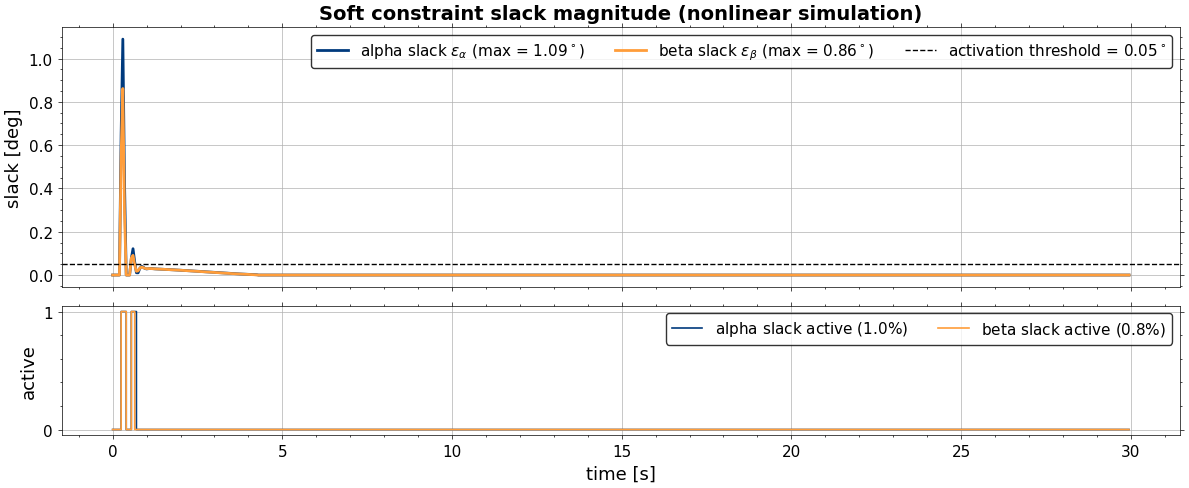

In [5]:
import numpy as np
import matplotlib.pyplot as plt

from plot_style import set_mpc_style
set_mpc_style()

LABEL_FONTSIZE = 13
TICK_FONTSIZE  = 11
TITLE_FONTSIZE = 14
LEGEND_FONTSIZE = 11

alpha_deg = np.rad2deg(alpha0)
beta_deg  = np.rad2deg(beta0)
thr_deg   = np.rad2deg(thr)

fig, axs = plt.subplots(
    2, 1,
    figsize=(12, 5),
    sharex=True,
    gridspec_kw={"height_ratios": [2, 1]}
)

# Top: slack magnitude

axs[0].plot(
    t, alpha_deg,
    label=fr"alpha slack $\epsilon_\alpha$ (max = {np.max(alpha_deg):.2f}$^\circ$)",
    linewidth=2
)
axs[0].plot(
    t, beta_deg,
    label=fr"beta slack $\epsilon_\beta$ (max = {np.max(beta_deg):.2f}$^\circ$)",
    linewidth=2
)
axs[0].axhline(
    thr_deg,
    linestyle="--",
    linewidth=1,
    color="black",
    label=fr"activation threshold = {thr_deg:.2f}$^\circ$"
)
axs[0].set_ylabel("slack [deg]",fontsize=LABEL_FONTSIZE)
axs[0].set_title("Soft constraint slack magnitude (nonlinear simulation)",fontsize=TITLE_FONTSIZE, fontweight="bold")
axs[0].tick_params(labelsize=TICK_FONTSIZE)
axs[0].grid(True)
handles, labels = axs[0].get_legend_handles_labels()
axs[0].legend(handles, labels, loc="upper right", ncol=3, fontsize=LEGEND_FONTSIZE, frameon=True,
           fancybox=True, edgecolor="black",
)

# Bottom: activation

axs[1].step(
    t,
    alpha_used.astype(int),
    where="post",
    label=fr"alpha slack active ({alpha_active_pct:.1f}$\%$)"
)
axs[1].step(
    t,
    beta_used.astype(int),
    where="post",
    label=fr"beta slack active ({beta_active_pct:.1f}$\%$)"
)
axs[1].set_yticks([0, 1])
axs[1].set_ylabel("active",fontsize=LABEL_FONTSIZE)
axs[1].set_xlabel("time [s]",fontsize=LABEL_FONTSIZE)
axs[1].tick_params(labelsize=TICK_FONTSIZE)
axs[1].grid(True)
handles, labels = axs[1].get_legend_handles_labels()
axs[1].legend(handles, labels, loc="upper right", ncol=3, fontsize=LEGEND_FONTSIZE, frameon=True,
           fancybox=True, edgecolor="black",
)

plt.tight_layout()
plt.savefig("slack_usage_over_time.pdf", bbox_inches="tight")
plt.show()



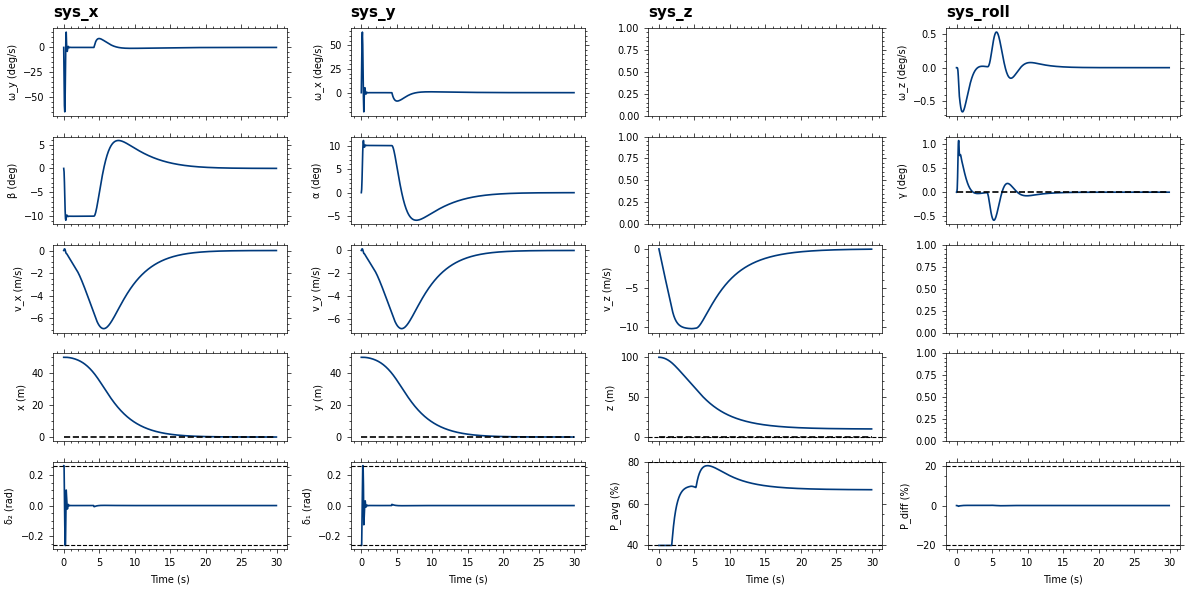

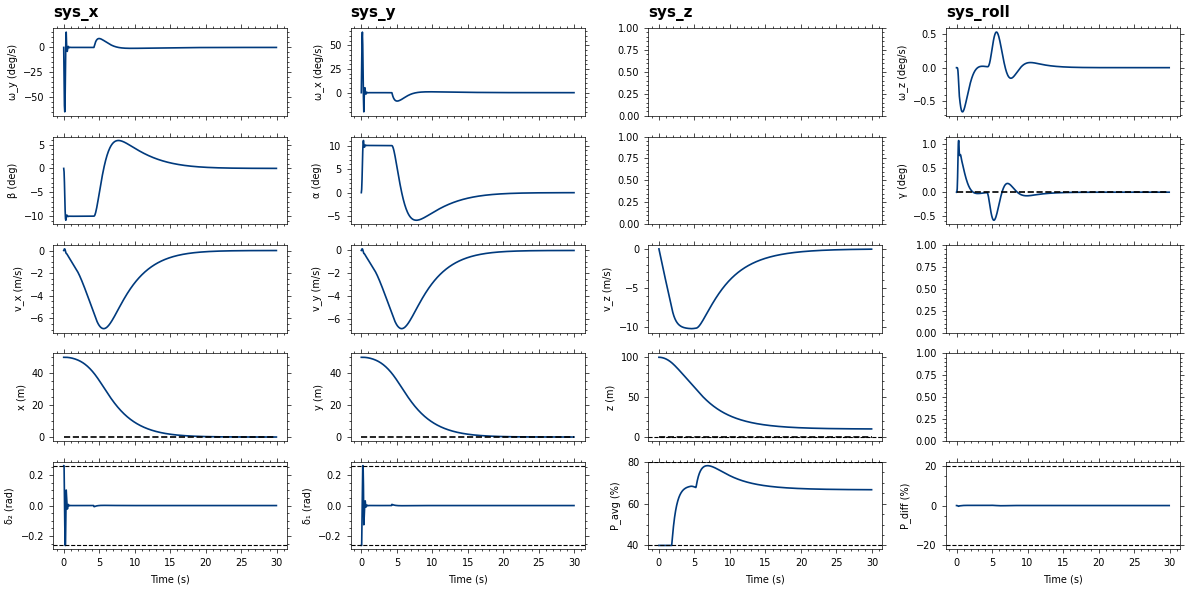

In [6]:
from src.vel_rocket_vis import plot_static_states_inputs
import matplotlib.pyplot as plt

T = t_cl[:-1]
X = x_cl[:, :-1]
U = u_cl
ref = ref[:,:-1]

plot_static_states_inputs(T, X, U, ref)
plt.savefig("Non_lin_closedloop_states_inputs.pdf", bbox_inches="tight")
plt.show()

Not yet convgerged at iteration 1
Not yet convgerged at iteration 2
Not yet convgerged at iteration 3
Not yet convgerged at iteration 4
Not yet convgerged at iteration 5
Not yet convgerged at iteration 6
Not yet convgerged at iteration 7
Not yet convgerged at iteration 8
Not yet convgerged at iteration 9
Maximum invariant set found after 10 iterations !

Not yet convgerged at iteration 1
Not yet convgerged at iteration 2
Not yet convgerged at iteration 3
Not yet convgerged at iteration 4
Not yet convgerged at iteration 5
Not yet convgerged at iteration 6
Not yet convgerged at iteration 7
Not yet convgerged at iteration 8
Not yet convgerged at iteration 9
Maximum invariant set found after 10 iterations !

Maximum invariant set found after 1 iterations !

Not yet convgerged at iteration 1
Not yet convgerged at iteration 2
Not yet convgerged at iteration 3
Not yet convgerged at iteration 4
Not yet convgerged at iteration 5
Not yet convgerged at iteration 6
Not yet convgerged at iteration 

h_l[i] and h_u[i] are both close to -/+ infinity for i = 600 (and potentially other indices).
PIQP is setting the corresponding rows in G to zero (sparsity structure preserving).
Consider removing the corresponding constraints for faster solves.
h_l[i] and h_u[i] are both close to -/+ infinity for i = 600 (and potentially other indices).
PIQP is setting the corresponding rows in G to zero (sparsity structure preserving).
Consider removing the corresponding constraints for faster solves.
h_l[i] and h_u[i] are both close to -/+ infinity for i = 360 (and potentially other indices).
PIQP is setting the corresponding rows in G to zero (sparsity structure preserving).
Consider removing the corresponding constraints for faster solves.
h_l[i] and h_u[i] are both close to -/+ infinity for i = 480 (and potentially other indices).
PIQP is setting the corresponding rows in G to zero (sparsity structure preserving).
Consider removing the corresponding constraints for faster solves.



Simulating time 0.05: 
 State z violation: -0.00 < 0.00, 
Simulating time 0.10: 
 State z violation: -0.00 < 0.00, 
Simulating time 0.15: 
 State z violation: -0.00 < 0.00, 
Simulating time 0.20: 
 State alpha violation: -0.18 < -0.17, 
 State z violation: -0.01 < 0.00, 
 State beta violation: 0.18 > 0.17, 
Simulating time 0.25: 
 State alpha violation: -0.18 < -0.17, 
 State z violation: -0.01 < 0.00, 
 State beta violation: 0.18 > 0.17, 
Simulating time 0.30: 
 State alpha violation: -0.18 < -0.17, 
 State z violation: -0.02 < 0.00, 
 State beta violation: 0.18 > 0.17, 
Simulating time 0.35: 
 State alpha violation: -0.18 < -0.17, 
 State z violation: -0.02 < 0.00, 
 State beta violation: 0.18 > 0.17, 
Simulating time 0.40: 
 State alpha violation: -0.18 < -0.17, 
 State z violation: -0.03 < 0.00, 
 State beta violation: 0.18 > 0.17, 
Simulating time 0.45: 
 State alpha violation: -0.18 < -0.17, 
 State z violation: -0.03 < 0.00, 
 State beta violation: 0.18 > 0.17, 
Simulating time

h_l[i] and h_u[i] are both close to -/+ infinity for i = 600 (and potentially other indices).
PIQP is setting the corresponding rows in G to zero (sparsity structure preserving).
Consider removing the corresponding constraints for faster solves.
h_l[i] and h_u[i] are both close to -/+ infinity for i = 600 (and potentially other indices).
PIQP is setting the corresponding rows in G to zero (sparsity structure preserving).
Consider removing the corresponding constraints for faster solves.
h_l[i] and h_u[i] are both close to -/+ infinity for i = 360 (and potentially other indices).
PIQP is setting the corresponding rows in G to zero (sparsity structure preserving).
Consider removing the corresponding constraints for faster solves.
h_l[i] and h_u[i] are both close to -/+ infinity for i = 480 (and potentially other indices).
PIQP is setting the corresponding rows in G to zero (sparsity structure preserving).
Consider removing the corresponding constraints for faster solves.



Simulating time 0.05: 
Simulating time 0.10: 
Simulating time 0.15: 
Simulating time 0.20: 
Simulating time 0.25: 
Simulating time 0.30: 
Simulating time 0.35: 
Simulating time 0.40: 
Simulating time 0.45: 
Simulating time 0.50: 
Simulating time 0.55: 
Simulating time 0.60: 
Simulating time 0.65: 
Simulating time 0.70: 
Simulating time 0.75: 
Simulating time 0.80: 
Simulating time 0.85: 
Simulating time 0.90: 
Simulating time 0.95: 
Simulating time 1.00: 
Simulating time 1.05: 
Simulating time 1.10: 
Simulating time 1.15: 
Simulating time 1.20: 
Simulating time 1.25: 
Simulating time 1.30: 
Simulating time 1.35: 
Simulating time 1.40: 
Simulating time 1.45: 
Simulating time 1.50: 
Simulating time 1.55: 
Simulating time 1.60: 
Simulating time 1.65: 
Simulating time 1.70: 
Simulating time 1.75: 
Simulating time 1.80: 
Simulating time 1.85: 
Simulating time 1.90: 
Simulating time 1.95: 
Simulating time 2.00: 
Simulating time 2.05: 
Simulating time 2.10: 
Simulating time 2.15: 
Simulating

h_l[i] and h_u[i] are both close to -/+ infinity for i = 600 (and potentially other indices).
PIQP is setting the corresponding rows in G to zero (sparsity structure preserving).
Consider removing the corresponding constraints for faster solves.
h_l[i] and h_u[i] are both close to -/+ infinity for i = 600 (and potentially other indices).
PIQP is setting the corresponding rows in G to zero (sparsity structure preserving).
Consider removing the corresponding constraints for faster solves.
h_l[i] and h_u[i] are both close to -/+ infinity for i = 360 (and potentially other indices).
PIQP is setting the corresponding rows in G to zero (sparsity structure preserving).
Consider removing the corresponding constraints for faster solves.
h_l[i] and h_u[i] are both close to -/+ infinity for i = 480 (and potentially other indices).
PIQP is setting the corresponding rows in G to zero (sparsity structure preserving).
Consider removing the corresponding constraints for faster solves.



Simulating time 0.05: 
Simulating time 0.10: 
Simulating time 0.15: 
Simulating time 0.20: 
Simulating time 0.25: 
Simulating time 0.30: 
Simulating time 0.35: 
Simulating time 0.40: 
Simulating time 0.45: 
Simulating time 0.50: 
Simulating time 0.55: 
Simulating time 0.60: 
Simulating time 0.65: 
Simulating time 0.70: 
Simulating time 0.75: 
Simulating time 0.80: 
Simulating time 0.85: 
Simulating time 0.90: 
Simulating time 0.95: 
Simulating time 1.00: 
Simulating time 1.05: 
Simulating time 1.10: 
Simulating time 1.15: 
Simulating time 1.20: 
Simulating time 1.25: 
Simulating time 1.30: 
Simulating time 1.35: 
Simulating time 1.40: 
Simulating time 1.45: 
Simulating time 1.50: 
Simulating time 1.55: 
Simulating time 1.60: 
Simulating time 1.65: 
Simulating time 1.70: 
Simulating time 1.75: 
Simulating time 1.80: 
Simulating time 1.85: 
Simulating time 1.90: 
Simulating time 1.95: 
Simulating time 2.00: 
Simulating time 2.05: 
Simulating time 2.10: 
Simulating time 2.15: 
Simulating

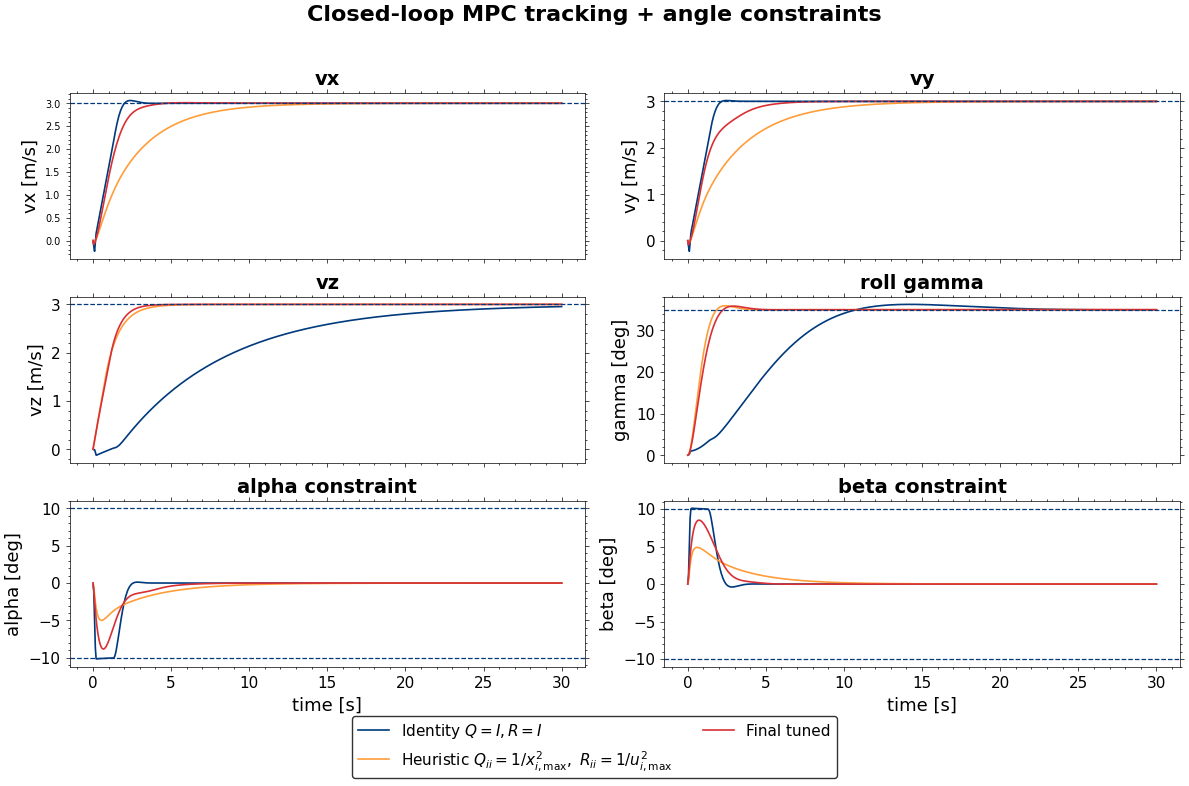

In [7]:
# Plot closed-loop over sim-time = 7 to check that vx, vy still satisfy convergence constarints of deliverable 3
# Check that tracking performance still is good


import numpy as np
import matplotlib.pyplot as plt

from plot_style import set_mpc_style
set_mpc_style()

sim_time = 30

rocket = Rocket(Ts=Ts, model_params_filepath=rocket_params_path)
xs, us = rocket.trim()
x0 = xs.copy()

x_ref = xs.copy()
x_ref[6] = 3.0
x_ref[7] = 3.0
x_ref[8] = 3.0
x_ref[5] = np.deg2rad(35.0)

# 1) Import the base MPCVelControl class (the one that has get_u etc.)
from MPCVelControl_D4_1 import MPCVelControl

# 2) Import the MPC subsystem controller classes
from MPCControl_xvel_D4_1 import MPCControl_xvel, MPCControl_xvel_tuned_default, MPCControl_xvel_tuned_final
from MPCControl_yvel_D4_1 import MPCControl_yvel, MPCControl_yvel_tuned_default, MPCControl_yvel_tuned_final
from MPCControl_zvel_D4_1 import MPCControl_zvel, MPCControl_zvel_tuned_default, MPCControl_zvel_tuned_final
from MPCControl_roll_D4_1 import MPCControl_roll, MPCControl_roll_tuned_default, MPCControl_roll_tuned_final

# 3) Define the 3 variants
class MPCVelControl_I(MPCVelControl):
    def new_controller(self, rocket, Ts, H):
        self.xs, self.us = rocket.trim()
        A, B = rocket.linearize(self.xs, self.us)
        self.mpc_x    = MPCControl_xvel(A, B, self.xs, self.us, Ts, H)
        self.mpc_y    = MPCControl_yvel(A, B, self.xs, self.us, Ts, H)
        self.mpc_z    = MPCControl_zvel(A, B, self.xs, self.us, Ts, H)
        self.mpc_roll = MPCControl_roll(A, B, self.xs, self.us, Ts, H)
        return self

class MPCVelControl_TD(MPCVelControl):
    def new_controller(self, rocket, Ts, H):
        self.xs, self.us = rocket.trim()
        A, B = rocket.linearize(self.xs, self.us)
        self.mpc_x    = MPCControl_xvel_tuned_default(A, B, self.xs, self.us, Ts, H)
        self.mpc_y    = MPCControl_yvel_tuned_default(A, B, self.xs, self.us, Ts, H)
        self.mpc_z    = MPCControl_zvel_tuned_default(A, B, self.xs, self.us, Ts, H)
        self.mpc_roll = MPCControl_roll_tuned_default(A, B, self.xs, self.us, Ts, H)
        return self

class MPCVelControl_TF(MPCVelControl):
    def new_controller(self, rocket, Ts, H):
        self.xs, self.us = rocket.trim()
        A, B = rocket.linearize(self.xs, self.us)
        self.mpc_x    = MPCControl_xvel_tuned_final(A, B, self.xs, self.us, Ts, H)
        self.mpc_y    = MPCControl_yvel_tuned_final(A, B, self.xs, self.us, Ts, H)
        self.mpc_z    = MPCControl_zvel_tuned_final(A, B, self.xs, self.us, Ts, H)
        self.mpc_roll = MPCControl_roll_tuned_final(A, B, self.xs, self.us, Ts, H)
        return self


# --- controller sets (yours) ---
ctrl_sets_cl = {
    "Identity $Q=I,R=I$": MPCVelControl_I,
    r"Heuristic $Q_{ii}=1/x_{i,\max}^2,\ R_{ii}=1/u_{i,\max}^2$": MPCVelControl_TD,
    "Final tuned": MPCVelControl_TF,
}

def run_closed_loop(mpc_full_cls, method):
    mpc = mpc_full_cls().new_controller(rocket, Ts, H)
    t_cl, x_cl, u_cl, *_ = rocket.simulate_control(
        mpc, sim_time, H, x0, method=method, x_target=x_ref
    )
    return t_cl, x_cl, u_cl

# -----------------------------
# Run each controller ONCE
# -----------------------------
results = {}
for lbl, mpc_cls in ctrl_sets_cl.items():
    # pick one:
    # method = "linear"
    method = "nonlinear"
    results[lbl] = run_closed_loop(mpc_cls, method=method)

# -----------------------------
# Plot tracking + angles (3x2)
# -----------------------------
fig, axs = plt.subplots(3, 2, figsize=(12, 8), sharex=True)
fig.suptitle("Closed-loop MPC tracking + angle constraints", fontsize=16, fontweight="bold")

def hline(ax, y):
    ax.axhline(y, linestyle="--", linewidth=0.9)

LABEL_FONTSIZE = 13
TICK_FONTSIZE  = 11
TITLE_FONTSIZE = 14
LEGEND_FONTSIZE = 11


# vx
ax = axs[0,0]
for lbl,(t,x,u) in results.items():
    ax.plot(t, x[6,:], label=lbl)
hline(ax, 3.0)
ax.set_ylabel("vx [m/s]", fontsize=LABEL_FONTSIZE)
ax.set_title("vx", fontsize=TITLE_FONTSIZE, fontweight="bold")

# vy
ax = axs[0,1]
for lbl,(t,x,u) in results.items():
    ax.plot(t, x[7,:], label=lbl)
hline(ax, 3.0)
ax.set_ylabel("vy [m/s]", fontsize=LABEL_FONTSIZE)
ax.set_title("vy", fontsize=TITLE_FONTSIZE, fontweight="bold")
ax.tick_params(labelsize=TICK_FONTSIZE)

# vz
ax = axs[1,0]
for lbl,(t,x,u) in results.items():
    ax.plot(t, x[8,:], label=lbl)
hline(ax, 3.0)
ax.set_ylabel("vz [m/s]", fontsize=LABEL_FONTSIZE)
ax.set_title("vz", fontsize=TITLE_FONTSIZE, fontweight="bold")
ax.tick_params(labelsize=TICK_FONTSIZE)

# gamma
ax = axs[1,1]
for lbl,(t,x,u) in results.items():
    ax.plot(t, np.rad2deg(x[5,:]), label=lbl)
hline(ax, 35.0)
ax.set_ylabel("gamma [deg]", fontsize=LABEL_FONTSIZE)
ax.set_title("roll gamma", fontsize=TITLE_FONTSIZE, fontweight="bold")
ax.tick_params(labelsize=TICK_FONTSIZE)


# alpha (idx 3) with ±10°
ax = axs[2,0]
for lbl,(t,x,u) in results.items():
    ax.plot(t, np.rad2deg(x[3,:]), label=lbl)
hline(ax, 10.0); hline(ax, -10.0)
ax.set_ylabel("alpha [deg]", fontsize=LABEL_FONTSIZE)
ax.set_title("alpha constraint", fontsize=TITLE_FONTSIZE, fontweight="bold")
ax.tick_params(labelsize=TICK_FONTSIZE)


# beta (idx 4) with ±10°
ax = axs[2,1]
for lbl,(t,x,u) in results.items():
    ax.plot(t, np.rad2deg(x[4,:]), label=lbl)
hline(ax, 10.0); hline(ax, -10.0)
ax.set_ylabel("beta [deg]", fontsize=LABEL_FONTSIZE)
ax.set_title("beta constraint", fontsize=TITLE_FONTSIZE, fontweight="bold")
ax.tick_params(labelsize=TICK_FONTSIZE)


for ax in axs[-1,:]:
    ax.set_xlabel("time [s]", fontsize=LABEL_FONTSIZE)

handles, labels = axs[0,0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center", ncol=2, fontsize=LEGEND_FONTSIZE, frameon=True,
    fancybox=True,
    edgecolor="black",title_fontsize=LEGEND_FONTSIZE)
plt.tight_layout(rect=[0, 0.08, 1, 0.95])
fig.savefig("closed_loop_mpc_tracking_n_angles.pdf", bbox_inches="tight")

plt.show()


In [8]:
# Code below is used for comparison for Deliverble 5.1

In [9]:
Ts = 0.05
sim_time = 15; H = 6.0
x0 = np.array([0, 0, 0, 0, 0, 0, 5, 5, 10, 0, 0, 1])  # initial state
x_target = np.zeros((12,))

rocket = Rocket(Ts=Ts, model_params_filepath=rocket_params_path)
mpc = MPCVelControl().new_controller(rocket, Ts, H)

# Static mass change and zero fuel rate
rocket.mass = 1.5
rocket.fuel_rate = 0.0
t_cl, x_cl, u_cl, t_ol, x_ol, u_ol, ref = rocket.simulate_control(mpc, sim_time, H, x0, x_target=x_target, method='nonlinear')


Not yet convgerged at iteration 1
Not yet convgerged at iteration 2
Not yet convgerged at iteration 3
Not yet convgerged at iteration 4
Not yet convgerged at iteration 5
Not yet convgerged at iteration 6
Not yet convgerged at iteration 7
Not yet convgerged at iteration 8
Not yet convgerged at iteration 9
Not yet convgerged at iteration 10
Not yet convgerged at iteration 11
Not yet convgerged at iteration 12
Not yet convgerged at iteration 13
Not yet convgerged at iteration 14
Not yet convgerged at iteration 15
Not yet convgerged at iteration 16
Not yet convgerged at iteration 17
Not yet convgerged at iteration 18
Maximum invariant set found after 19 iterations !

Not yet convgerged at iteration 1
Not yet convgerged at iteration 2
Not yet convgerged at iteration 3
Not yet convgerged at iteration 4
Not yet convgerged at iteration 5
Not yet convgerged at iteration 6
Not yet convgerged at iteration 7
Not yet convgerged at iteration 8
Not yet convgerged at iteration 9
Not yet convgerged at 

h_l[i] and h_u[i] are both close to -/+ infinity for i = 600 (and potentially other indices).
PIQP is setting the corresponding rows in G to zero (sparsity structure preserving).
Consider removing the corresponding constraints for faster solves.
h_l[i] and h_u[i] are both close to -/+ infinity for i = 600 (and potentially other indices).
PIQP is setting the corresponding rows in G to zero (sparsity structure preserving).
Consider removing the corresponding constraints for faster solves.
h_l[i] and h_u[i] are both close to -/+ infinity for i = 360 (and potentially other indices).
PIQP is setting the corresponding rows in G to zero (sparsity structure preserving).
Consider removing the corresponding constraints for faster solves.
h_l[i] and h_u[i] are both close to -/+ infinity for i = 480 (and potentially other indices).
PIQP is setting the corresponding rows in G to zero (sparsity structure preserving).
Consider removing the corresponding constraints for faster solves.



Simulating time 0.05: 
Simulating time 0.10: 
Simulating time 0.15: 
Simulating time 0.20: 
Simulating time 0.25: 
Simulating time 0.30: 
Simulating time 0.35: 
 State beta violation: -0.18 < -0.17, 
 State alpha violation: 0.18 > 0.17, 
Simulating time 0.40: 
 State beta violation: -0.18 < -0.17, 
 State alpha violation: 0.18 > 0.17, 
Simulating time 0.45: 
 State beta violation: -0.18 < -0.17, 
 State alpha violation: 0.18 > 0.17, 
Simulating time 0.50: 
Simulating time 0.55: 
Simulating time 0.60: 
Simulating time 0.65: 
 State beta violation: -0.17 < -0.17, 
 State alpha violation: 0.17 > 0.17, 
Simulating time 0.70: 
 State beta violation: -0.17 < -0.17, 
 State alpha violation: 0.18 > 0.17, 
Simulating time 0.75: 
 State beta violation: -0.17 < -0.17, 
 State alpha violation: 0.17 > 0.17, 
Simulating time 0.80: 
 State beta violation: -0.17 < -0.17, 
Simulating time 0.85: 
Simulating time 0.90: 
 State beta violation: -0.17 < -0.17, 
 State alpha violation: 0.17 > 0.17, 
Simulat

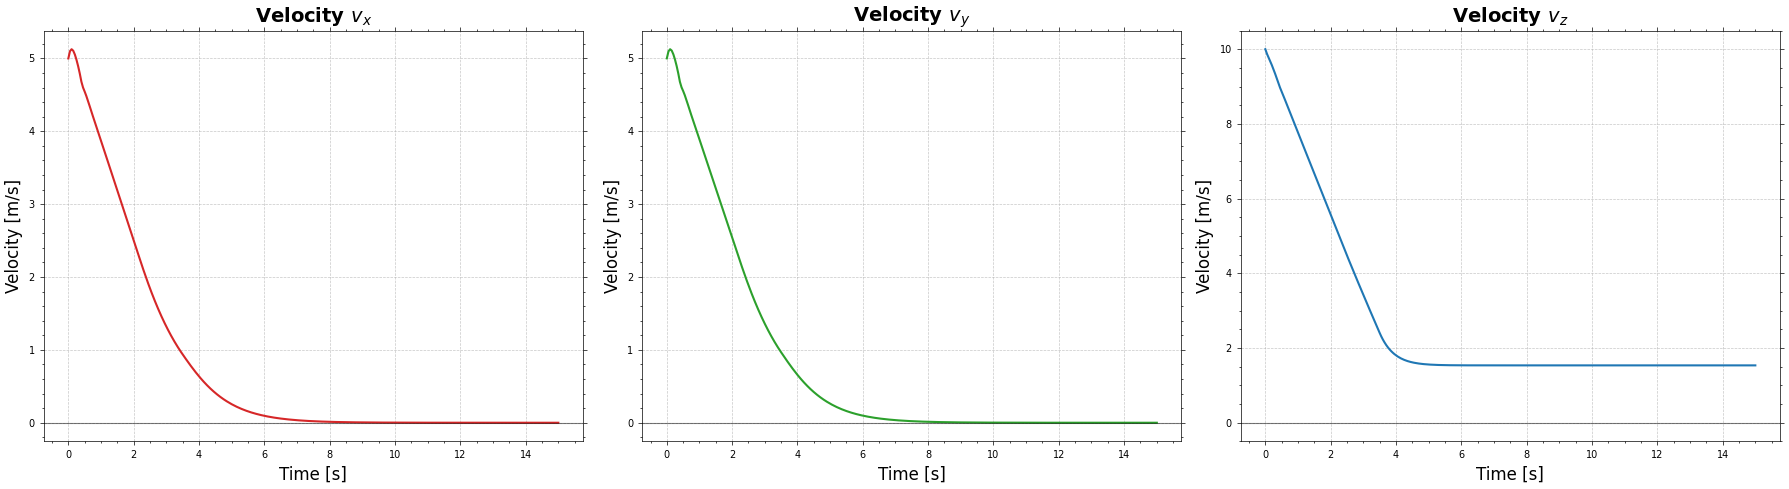

In [10]:
def plot_velocities_side_by_side(t_vector, x_trajectory):
    """
    Plots vx, vy, and vz velocities side-by-side.
    
    Args:
        t_vector: Time vector from simulation (t_cl)
        x_trajectory: Full state trajectory (12 x N matrix)
    """
    # Define indices for velocities: vx=6, vy=7, vz=8
    v_indices = [6, 7, 8]
    v_names = [r'$v_x$', r'$v_y$', r'$v_z$']
    v_colors = ['tab:red', 'tab:green', 'tab:blue']

    fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=False)

    for i, ax in enumerate(axes):
        idx = v_indices[i]
        ax.plot(t_vector, x_trajectory[idx, :], color=v_colors[i], linewidth=1.5)
        
        ax.set_title(f"Velocity {v_names[i]}", fontsize=14)
        ax.set_xlabel("Time [s]", fontsize=12)
        ax.set_ylabel("Velocity [m/s]", fontsize=12)
        ax.grid(True, linestyle='--', alpha=0.7)
        
        # Add a horizontal line at 0 for reference
        ax.axhline(0, color='black', linestyle='-', linewidth=0.8, alpha=0.5)

    plt.tight_layout()
    plt.savefig("Vx_Vy_Vz_4.1.pdf", bbox_inches="tight")
    plt.show()

plot_velocities_side_by_side(t_cl, x_cl)